Task 1 of The Forage Quantitative Research Module | JPMC

            Prices
Dates             
2020-10-31    10.1
2020-11-30    10.3
2020-12-31    11.0
2021-01-31    10.9
2021-02-28    10.9


C:\Users\adedo\AppData\Local\Temp\ipykernel_30044\2420522258.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


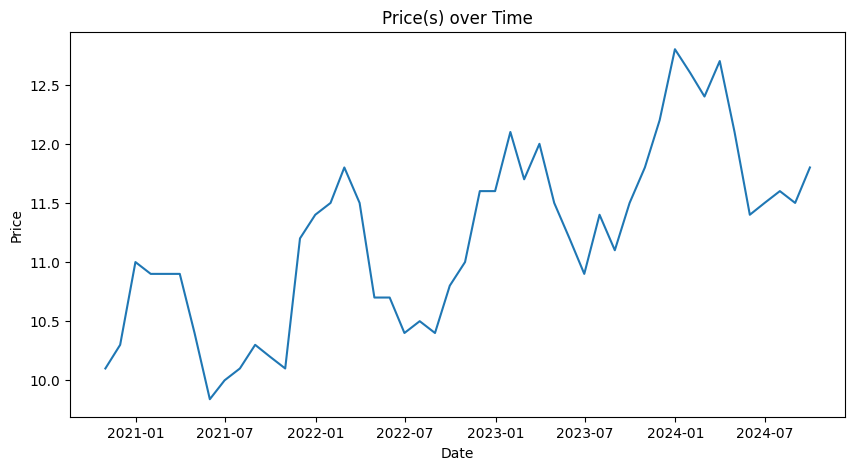

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/natural_gas.csv')

df['Dates'] = pd.to_datetime(df['Dates'])
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')
df = df.set_index('Dates')
print(df.head())

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Prices'], label='Natural Gas Prices')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price(s) over Time")
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
import numpy as np

df['time_numeric'] = (df.index - df.index.min()).days

X = df['time_numeric'].values.reshape(-1, 1)
y = df['Prices'].values
model = LinearRegression()
model.fit(X, y)

user_date = input("Enter a future date (YYYY-MM-DD) to predict the price: ")
future_date = pd.to_datetime(user_date)

# Convert to numeric (same scale as training data)
future_numeric = (future_date - df.index.min()).days

predicted_price = model.predict([[future_numeric]])[0]

print(f"Predicted price on {user_date}: {predicted_price:.2f}")

Predicted price on 2025-09-09: 12.57


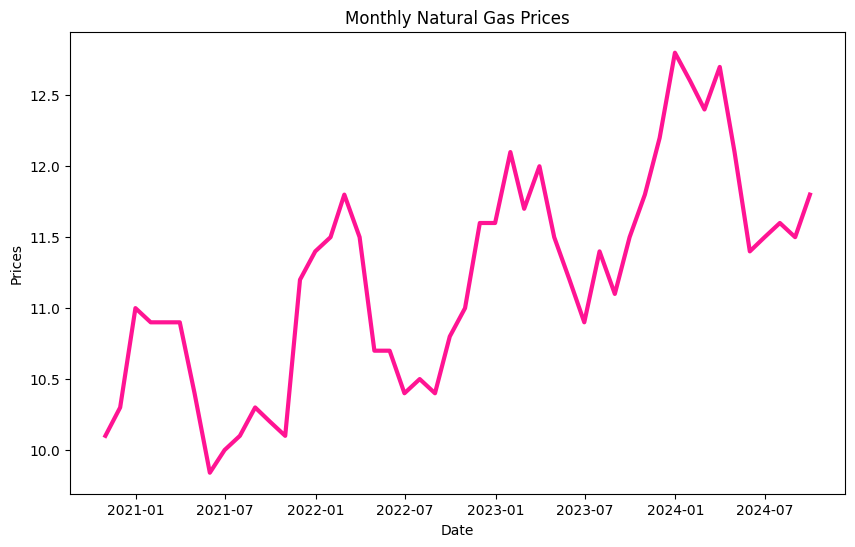

In [8]:
# Sarima Model Prediction https://www.geeksforgeeks.org/machine-learning/sarima-seasonal-autoregressive-integrated-moving-average/

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

df  = pd.read_csv('data/natural_gas.csv')
data = df[['Dates', 'Prices']]
data['Dates'] = pd.to_datetime(data['Dates'], format="%m/%d/%y")
data.head()

df1 = data.set_index('Dates')
monthly_data = df1.resample('ME').sum()
monthly_data.head()

plt.figure(figsize=(10,6))
plt.plot(monthly_data['Prices'], linewidth=3, c='deeppink')
plt.title("Monthly Natural Gas Prices")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag="AIC")
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

monthly_data['price_diff'] = monthly_data['Prices'].diff()
check_stationarity(monthly_data['price_diff'].dropna())

ADF Statistic: -6.844773557477345
p-value: 1.754169685294091e-09
Stationary


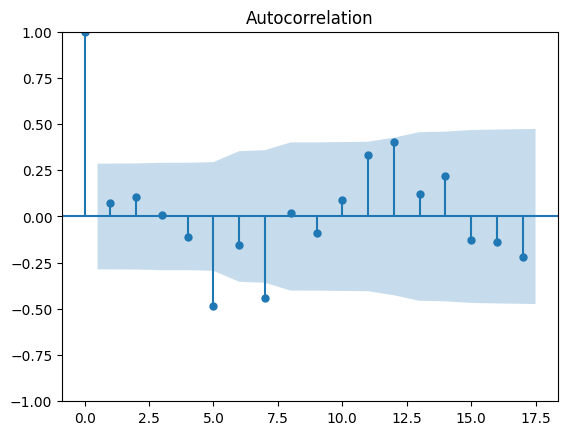

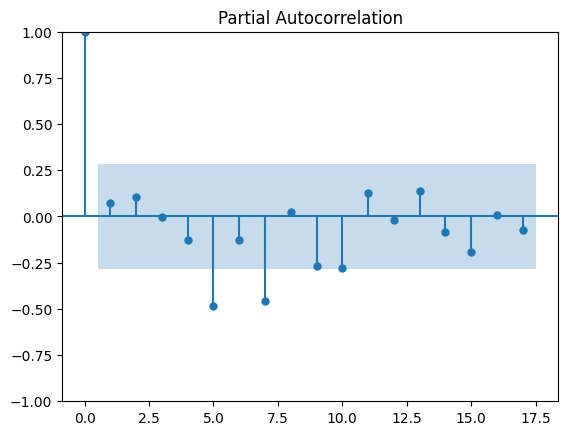

In [13]:
plot_acf(monthly_data['price_diff'].dropna())
plot_pacf(monthly_data['price_diff'].dropna())
plt.show()

In [18]:
p, d, q = 1, 1, 1
P, D, Q, S = 1, 1, 1, 12

model = SARIMAX(monthly_data['price_diff'].dropna(), order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

C:\Users\adedo\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\adedo\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


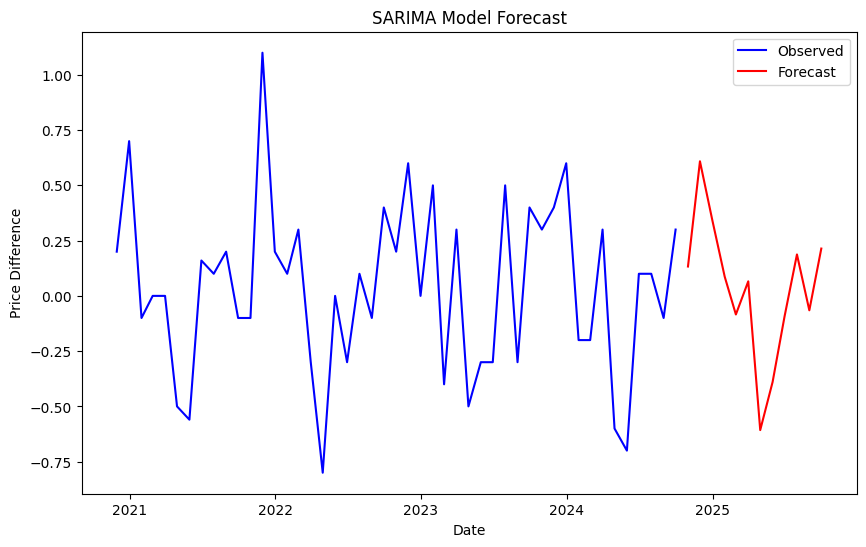

In [20]:
forecast_periods = 12
forecast = results.forecast(steps=forecast_periods)

plt.figure(figsize=(10,6))
plt.plot(monthly_data['price_diff'].dropna(), label='Observed', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.title("SARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Price Difference")
plt.legend()
plt.show()

In [22]:
# Take last 12 months as observed values
observed = monthly_data['price_diff'].dropna().tail(forecast_periods)

mae = mean_absolute_error(observed, forecast)
mse = mean_squared_error(observed, forecast)

print("MAE:", mae)
print("MSE:", mse)

MAE: 0.16571652646824603
MSE: 0.036515550632308526
